<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The MoonLander Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The MoonLander Problem:* The MoonLander problem is a classic optimal control problem where we aim to land a spacecraft on the moon while minimizing the time of flight.
The problem is inspired from the following paper: [FATROP : A Fast Constrained Optimal Control Problem Solver for Robot Trajectory Optimization and Control](https://arxiv.org/pdf/2303.16746) made for [Casadi](https://web.casadi.org/) software and [Fatrop](https://github.com/meco-group/fatrop) solver.                            
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)
4. [Remarks](#rem)

</div>

In [1]:
import Pkg
Pkg.activate("..")
include("./utils.jl");
using OptimalControlProblems
using Plots
using MKL
import HSL_jll
nh = 100;

  Activating project at `~/ENSEEIHT/Stage/CTBenchmarks.jl`


## 1. Solving with JuMP <a id='jump'></a>

In [2]:
using JuMP , Ipopt

MoonLander = moonlander(JuMPBackend();nh=nh)

set_optimizer(MoonLander,Ipopt.Optimizer)
set_attribute(MoonLander, "print_level", 5)
set_optimizer_attribute(MoonLander,"tol",1e-8)
set_optimizer_attribute(MoonLander,"constr_viol_tol",1e-6)
set_optimizer_attribute(MoonLander,"max_iter",1000)
set_optimizer_attribute(MoonLander,"mu_strategy","adaptive")
#set_attribute(MoonLander, "hsllib", HSL_jll.libhsl_path)
#set_attribute(MoonLander, "linear_solver", "ma57")
set_optimizer_attribute(MoonLander, "print_timing_statistics", "yes")

In [3]:
println("Solving...")
optimize!(MoonLander)
println()
# Display results
if termination_status(MoonLander) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(MoonLander) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(MoonLander) == MOI.TIME_LIMIT && has_values(MoonLander)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(MoonLander))
println()

step = MoonLander[:step]

p1 = MoonLander[:p1];
p2 = MoonLander[:p2];
dp1 = MoonLander[:dp1];
dp2 = MoonLander[:dp2];
theta = MoonLander[:theta];
dtheta = MoonLander[:dtheta];

F1 = MoonLander[:F1];
F2 = MoonLander[:F2];

d_p1 = MoonLander[:d_p1];
d_p2 = MoonLander[:d_p2];
d_dp1 = MoonLander[:d_dp1];
d_dp2 = MoonLander[:d_dp2];
d_theta = MoonLander[:d_theta];
d_dtheta = MoonLander[:d_dtheta];


Δt = value(step);
t = Vector((0:nh)*Δt); 

p = - [[ dual(d_p1[i]), dual(d_p2[i]), dual(d_dp1[i]), dual(d_dp2[i]), dual(d_theta[i]), dual(d_dtheta[i]) ] for i in 1:nh];
p = costateInterpolation(p, t);

p1 = Vector(value.(p1)) ;
p2 = Vector(value.(p2)) ;
dp1 = Vector(value.(dp1)) ;
dp2 = Vector(value.(dp2)) ;
theta = Vector(value.(theta)) ;
dtheta = Vector(value.(dtheta)) ;
F1 = Vector(value.(F1)) ;
F2 = Vector(value.(F2)) ;
u = [[F1[i], F2[i]] for i in 1:nh+1];

x =  [ [ p1[i], p2[i], dp1[i], dp2[i], theta[i], dtheta[i] ] for i in 1:nh+1];

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     5010
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10000

Total number of variables............................:      809
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      610
Total number of i

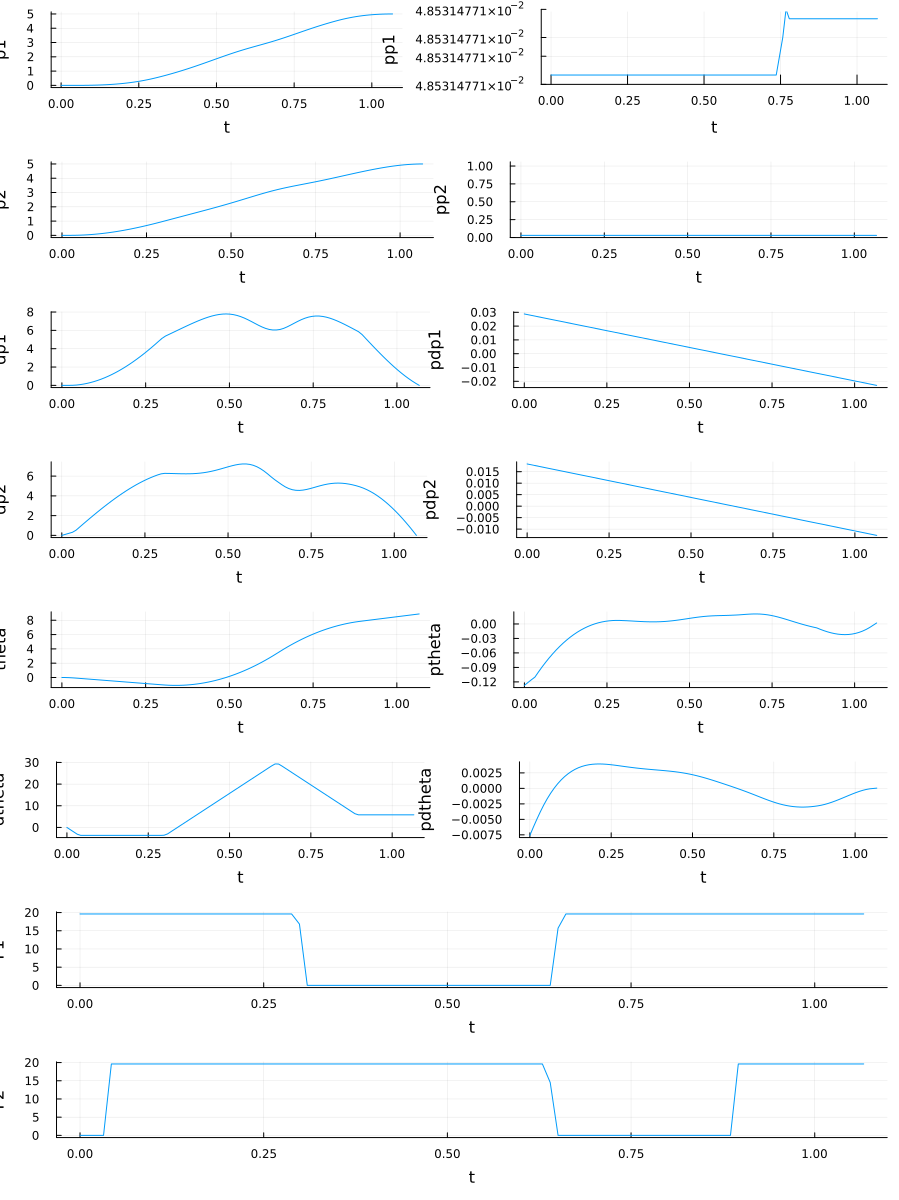

GKS: Possible loss of precision in routine SET_WINDOW


In [4]:
p1_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p1", legend = false)
p2_plot = plot(t, [ x[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "p2", legend = false)
dp1_plot = plot(t, [ x[i][3] for i in 1:nh+1], xlabel = "t", ylabel = "dp1", legend = false)
dp2_plot = plot(t, [ x[i][4] for i in 1:nh+1], xlabel = "t", ylabel = "dp2", legend = false)
theta_plot = plot(t, [ x[i][5] for i in 1:nh+1], xlabel = "t", ylabel = "theta", legend = false)
dtheta_plot = plot(t, [ x[i][6] for i in 1:nh+1], xlabel = "t", ylabel = "dtheta", legend = false)
pp1_plot = plot(t, [ p[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "pp1", legend = false)
pp2_plot = plot(t, [ p[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "pp2", legend = false)
pdp1_plot = plot(t, [ p[i][3] for i in 1:nh+1], xlabel = "t", ylabel = "pdp1", legend = false)
pdp2_plot = plot(t, [ p[i][4] for i in 1:nh+1], xlabel = "t", ylabel = "pdp2", legend = false)
ptheta_plot = plot(t, [ p[i][5] for i in 1:nh+1], xlabel = "t", ylabel = "ptheta", legend = false)
pdtheta_plot = plot(t, [ p[i][6] for i in 1:nh+1], xlabel = "t", ylabel = "pdtheta", legend = false)

F1_plot = plot(t, [ u[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "F1", legend = false)
F2_plot = plot(t, [ u[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "F2", legend = false)

layout = @layout [a b; c d; e f; g h ;j h; k l;o;p]
x_plot = plot(p1_plot, pp1_plot, p2_plot, pp2_plot, dp1_plot, pdp1_plot, dp2_plot, pdp2_plot, theta_plot, ptheta_plot, dtheta_plot, pdtheta_plot, F1_plot, F2_plot, layout = layout)
x_plot = plot!(x_plot, size = (900, 1200))
display(x_plot)

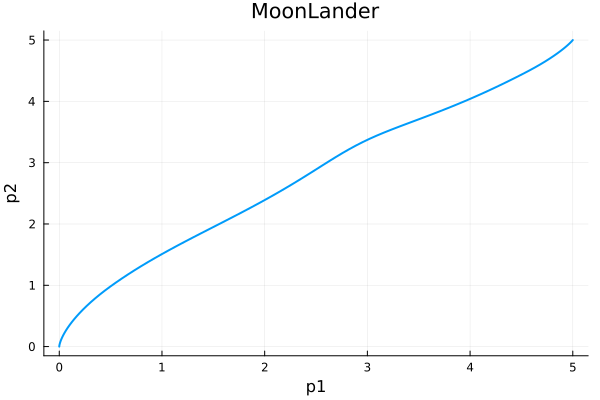

In [5]:
plot(
    p1,
    p2,
    linewidth = 2,
    legend = nothing,
    title = "MoonLander",
    xlabel = "p1",
    ylabel = "p2",
)

## 2. Solving with OptimalControl <a id='oc'></a>

In [6]:
using OptimalControl, NLPModelsIpopt
docp, MoonLanderOC = moonlander(OptimalControlBackend(); nh=nh);

In [7]:
# Solve the problem
nlp_sol = NLPModelsIpopt.ipopt(
    MoonLanderOC;
    print_level=5,
    tol=1e-8,
    mu_strategy="adaptive",
    sb="yes",
    constr_viol_tol=1e-6,
    max_iter=1000,
    print_timing_statistics="yes",
    #linear_solver="ma57",
    #hsllib=HSL_jll.libhsl_path,
)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     4410
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1111

Total number of variables............................:      809
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      610
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 4.90e+00 7.41e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00 

"Execution stats: unknown"

[0.0, -1.0396861912927753e18, -2.0793723825855506e18, -3.119058573878326e18, -4.158744765171101e18, -5.198430956463877e18, -6.238117147756652e18, -7.277803339049428e18, -8.317489530342202e18, -9.357175721634978e18, -1.0396861912927754e19, -1.1436548104220529e19, -1.2476234295513303e19, -1.351592048680608e19, -1.4555606678098856e19, -1.5595292869391628e19, -1.6634979060684405e19, -1.7674665251977181e19, -1.8714351443269956e19, -1.975403763456273e19, -2.079372382585551e19, -2.183341001714828e19, -2.2873096208441057e19, -2.3912782399733834e19, -2.4952468591026606e19, -2.5992154782319383e19, -2.703184097361216e19, -2.8071527164904935e19, -2.911121335619771e19, -3.015089954749048e19, -3.1190585738783257e19, -3.2230271930076033e19, -3.326995812136881e19, -3.4309644312661586e19, -3.5349330503954362e19, -3.6389016695247135e19, -3.742870288653991e19, -3.846838907783269e19, -3.950807526912546e19, -4.054776146041824e19, -4.158744765171102e19, -4.2627133843003785e19, -4.366682003429656e19, -4.4706

┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils /root/.julia/packages/PlotUtils/dVE

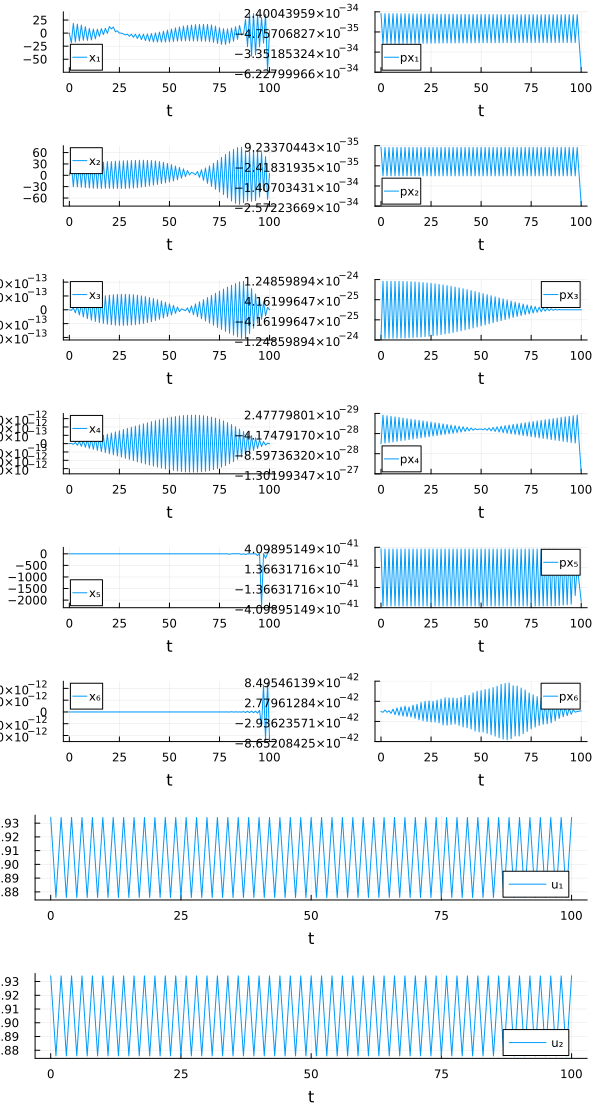

In [8]:
# Plot results
sol = build_OCP_solution(docp; primal=nlp_sol.solution, dual=nlp_sol.multipliers)
plot(sol)

## 3. Comparison <a id='comp'></a>

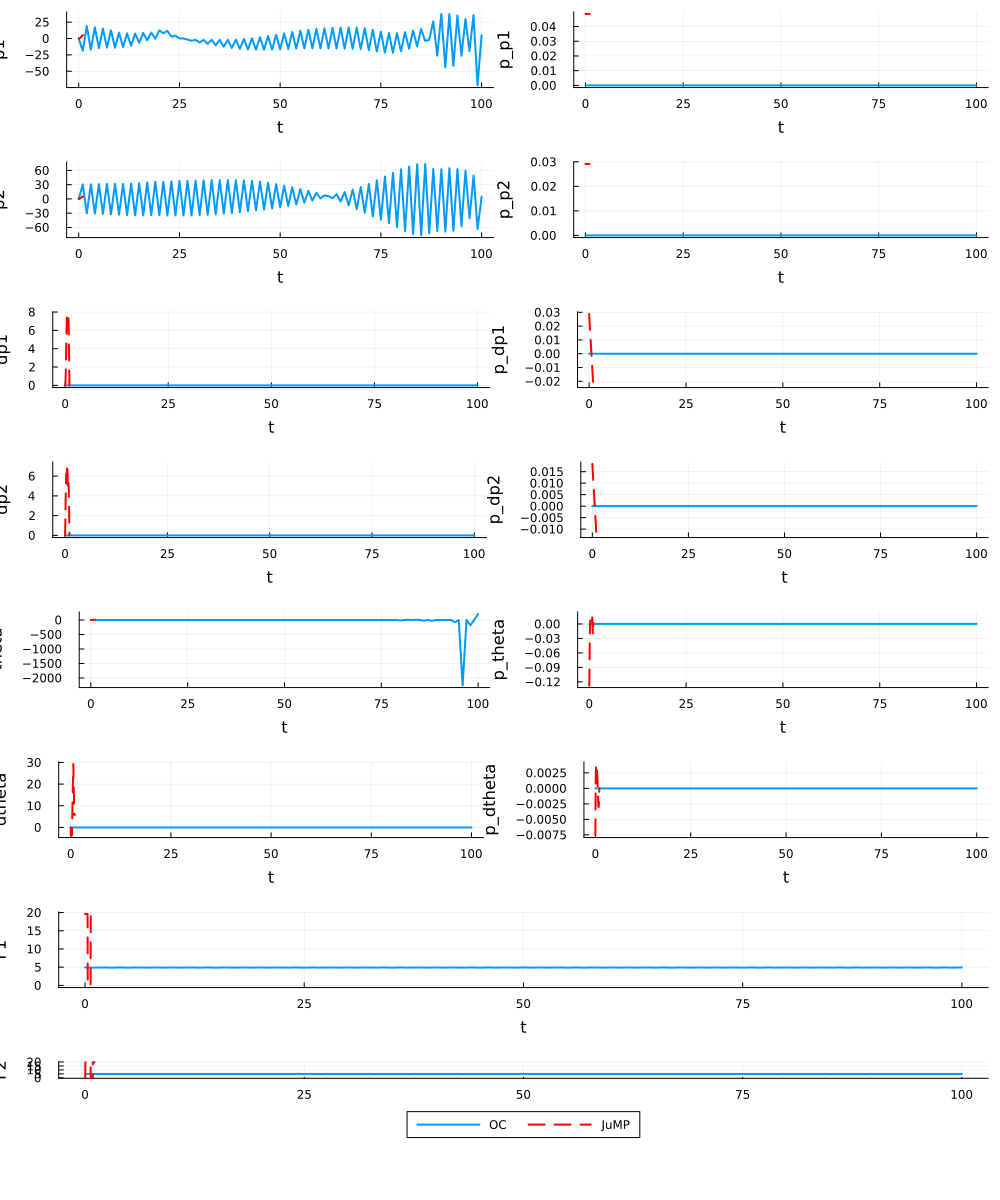

In [9]:
plt_p1 = plot(plot(sol)[1],line = 2)
plt_p1 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p2 = plot(plot(sol)[2],line = 2)
plt_p2 = plot!(t, [ x[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "p2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_dp1 = plot(plot(sol)[3],line = 2)
plt_dp1 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "dp1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_dp2 = plot(plot(sol)[4],line = 2)
plt_dp2 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "dp2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_theta = plot(plot(sol)[5],line = 2)
plt_theta = plot!(t, [ x[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "theta", legend = false,line = 2, color = "red",linestyle=:dash)

plt_dtheta = plot(plot(sol)[6],line = 2)
plt_dtheta = plot!(t, [ x[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "dtheta", legend = false,line = 2, color = "red",linestyle=:dash)

#

plt_pp1 = plot(plot(sol)[7],line = 2)
plt_pp1 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_p1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_p2 = plot(plot(sol)[8],line = 2)
plt_p_p2 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_p2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_dp1 = plot(plot(sol)[9],line = 2)
plt_p_dp1 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_dp1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_dp2 = plot(plot(sol)[10],line = 2)
plt_p_dp2 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_dp2", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_theta = plot(plot(sol)[11],line = 2)
plt_p_theta = plot!(t, [ p[i][5] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_theta", legend = false,line = 2, color = "red",linestyle=:dash)

plt_p_dtheta = plot(plot(sol)[12],line = 2)
plt_p_dtheta = plot!(t, [ p[i][6] for i in 1:nh+1 ], xlabel = "t", ylabel = "p_dtheta", legend = false,line = 2, color = "red",linestyle=:dash)

# 
plt_F1 = plot(plot(sol)[13],line = 2)
plt_F1 = plot!(t, [ u[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "F1", legend = false,line = 2, color = "red",linestyle=:dash)

plt_F2 = plot(plot(sol)[14], label ="OC",line = 2)
plt_F2 = plot!(t, [ u[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "F2", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
plt_F2 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h ;j h; o m;p; n]

x_plot =  plot( plt_p1, plt_pp1, plt_p2, plt_p_p2, plt_dp1, plt_p_dp1, plt_dp2, plt_p_dp2, plt_theta, plt_p_theta, plt_dtheta, plt_p_dtheta, plt_F1, plt_F2, layout = layout)
x_plot = plot!(x_plot, size = (1000, 1200))
display(x_plot)

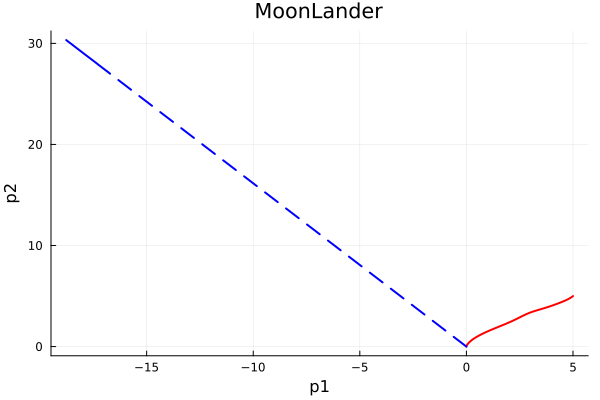

In [20]:
using JuMP
Δt = ones(nh)*step
ts = cumsum([0; value.(Δt)])[1:end-1]
x = [sol.state.value(t) for t in ts]
pf = plot(
    p1,
    p2,
    linewidth = 2,
    legend = nothing,
    title = "MoonLander",
    xlabel = "p1",
    ylabel = "p2",
    color = "red",
)
pf = plot!(
    [x[i][1] for i in 1:nh],
    [x[i][2] for i in 1:nh],
    linewidth = 2,
    legend = nothing,
    title = "MoonLander",
    xlabel = "p1",
    ylabel = "p2",
    color = "blue",
    linestyle=:dash
)